In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gameanalysis import rsgame, paygame, nash, learning
import numpy as np
import time
import matplotlib.pyplot as plt
import utils
from utils import CTFSim
import environment.wrapper as wrapper
import tqdm
import experiment

In [28]:
np.set_printoptions(precision=2, suppress=True)

## I. Estimating Computational Costs

### 1) Simulation time

In [15]:
def generate_symmetric_profile(num_players, num_strats, n=10):
    eg = rsgame.empty([num_players] * 2, [num_strats] * 2)
    return eg.random_profiles(n)

In [83]:
def estimate_simlation_time(num_players, num_strats, n=50):
    sim = CTFSim(num_players, render=False)
    profs = generate_symmetric_profile(num_players, num_strats, n)
    total_time = 0
    for i in range(n):
        begin = time.time()
        utils.simulate_profile(sim, profs[i])
        total_time += time.time() - begin
    return total_time / n

In [84]:
for i in range(3,7):
    t = estimate_simlation_time(i,4)
    print('Single simulation for a game with', i, 'players take:', t, 'seconds')

Single simulation for a game with 3 players take: 0.12513060569763185 seconds
Single simulation for a game with 4 players take: 0.18735039710998536 seconds
Single simulation for a game with 5 players take: 0.239103364944458 seconds
Single simulation for a game with 6 players take: 0.3272632455825806 seconds


### 2) Effective Simulation Steps

In [ ]:
# Experiment on effective number of simulation steps for the game to terminate
# Need to first change the num_step ceiling in the simulator before running this
effective_steps = np.zeros((4, 50))
for i in range(3,7):
    sim = CTFSim(i)
    profs = generate_symmetric_profile(i, 4, 50)
    for j in range(50):
        count = utils.count_effective_simulation_steps(sim, profs[j])
        effective_steps[i-3,j] = count

# Plotting
for i in range(4):
    plt.scatter(np.ones(50)*(i+3), effective_steps[i])
plt.plot(np.arange(4)+3, effective_steps.mean(1))
plt.xlabel('Number of players')
plt.ylabel('Number of steps')
plt.title('Effective Number of Simulation Steps (with a 400 step ceiling)')
plt.legend(['Average'])

### 3) Number of profiles

In [86]:
def get_num_profiles(players, num_strats):
    eg = rsgame.empty(players, [num_strats] * len(players))
    return len(eg.all_profiles())

In [ ]:
num_strats = 3
for i in range(3, 7):
    print('For a', i, '-player game')
    sym_players = [i] * 2
    print('Symmetric formulation has', get_num_profiles(sym_players,num_strats), 'profiles')
    ps_players = [i//2, i-i//2] * 2
    print('Partially sym. formulation has', get_num_profiles(ps_players,num_strats),'profiles')
    as_players = [1] * (2*i)
    print('Asymmetric formulation has', get_num_profiles(as_players,num_strats),'profiles')
    print('-'*30)

### 4) Time to find Nash

In [110]:
def estimate_nash_time(players, num_strats, n=50):
    eg = rsgame.empty(players, [num_strats] * len(players))
    profs = eg.all_profiles()
    total_time = 0
    for _ in range(n):
        pays = np.random.random(profs.shape)
        pays[profs==0] = 0
        pg = paygame.game(players, num_strats, profs, pays)
        begin = time.time()
        nash.replicator_dynamics(pg, pg.random_mixture())
        total_time += time.time() - begin
    return total_time / n

In [111]:
num_strats = 3
for i in range(3, 5):
    print('For a', i, '-player game')
    sym_players = [i] * 2
    print('Symmetric formulation takes', estimate_nash_time(sym_players,num_strats), 'seconds')
    ps_players = [i//2, i-i//2] * 2
    print('Partially sym. formulation takes', estimate_nash_time(ps_players,num_strats),'seconds')
    as_players = [1] * (2*i)
    print('Asymmetric formulation takes', estimate_nash_time(as_players,num_strats),'seconds')
    print('-'*30)

For a 3 -player game
Symmetric formulation takes 0.07951003551483155 seconds
Partially sym. formulation takes 0.3025855112075806 seconds
Asymmetric formulation takes 0.5647076272964477 seconds
------------------------------
For a 4 -player game
Symmetric formulation takes 0.2073976755142212 seconds
Partially sym. formulation takes 2.884492206573486 seconds
Asymmetric formulation takes 5.637944140434265 seconds
------------------------------


## II. Finding Equilibria

In [106]:
num_players=[4,2]
vels = [0.75, 0.75]
sim = wrapper.asymmetric_sim(num_players, max_vels=vels)

In [107]:
eqfinder = experiment.CTFEqFinder(num_players,2,sim=sim)

In [108]:
t = time.time()
eqfinder.find_eq(n=5)

[array([1., 0., 0., 1.]),
 array([1., 0., 0., 1.]),
 array([1., 0., 0., 1.]),
 array([1., 0., 0., 1.]),
 array([1., 0., 0., 1.])]

In [109]:
eq = nash.replicator_dynamics(eqfinder.game, eqfinder.game.random_mixture())
eq

array([1., 0., 0., 1.])

In [110]:
eqfinder.game.expected_payoffs(eq)

array([ 0.8, -0.8])

In [82]:
eqfinder.game.expected_payoffs(np.array([0.3,0.7,0.15,0.85]))

array([ 0.65, -0.65])

In [48]:
sim = wrapper.asymmetric_sim(num_players, max_vels=vels,render=False)
utils.simulate_profile(sim, np.array([0,3,2,0]), num_players)

array([0., 0., 0., 0.])

In [14]:
log = sim.get_logger()

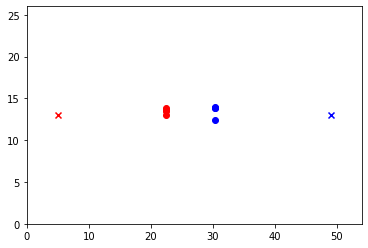

In [18]:
log.mp4_from_file('4v4.mp4')

# Other

In [7]:
N = 3
S = 4

In [8]:
players = [N,N]
strats = [S,S]

In [9]:
eg = rsgame.empty(players, strats)
profs = eg.all_profiles()

In [13]:
eg.random_profiles(10)

array([[1, 1, 0, 1, 1, 0, 1, 1],
       [2, 0, 1, 0, 1, 2, 0, 0],
       [0, 1, 1, 1, 0, 2, 1, 0],
       [1, 1, 0, 1, 1, 1, 0, 1],
       [1, 1, 1, 0, 1, 0, 0, 2],
       [1, 0, 1, 1, 1, 0, 0, 2],
       [0, 1, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 1, 0, 2, 0],
       [1, 0, 1, 1, 3, 0, 0, 0],
       [3, 0, 0, 0, 1, 1, 1, 0]])

In [72]:
print(len(profs))

400


In [73]:
sim = CTFSim(N, render=False)
pays = []
for i,p in enumerate(profs):
    pays.append(experiment.estimate_payoff(sim, p))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [76]:
pays = np.array(pays)
pays[profs==0] = 0

In [77]:
pg = paygame.game(players, strats, profs, pays)
pg

Game([3 3], [4 4], 400 / 400)

In [78]:
begin_time = time.time()
n = nash.replicator_dynamics(pg, pg.random_mixture()).reshape(-1, S)
print(time.time() - begin_time)

2.2823145389556885


In [79]:
n

array([[0.10387562, 0.4899783 , 0.04850823, 0.35763784],
       [0.02985288, 0.32617843, 0.14239354, 0.50157515]])

# Partial profiles

In [78]:
# Partial Profiles
inds = np.random.choice(pays.shape[0], 100, replace=False)
pays_partial = pays[inds]
profs_partial = profs[inds]

In [79]:
pg = paygame.game(players, strats, profs_partial, pays_partial)

In [84]:
rg = learning.nngame_train(pg)

ModuleNotFoundError: No module named 'keras'

In [83]:
begin_time = time.time()
nash.replicator_dynamics(pg, pg.random_mixture()).reshape(-1, S)
print(time.time() - begin_time)

/home/jack/.virtualenvs/277project/lib/python3.6/site-packages/gameanalysis/paygame.py:171: RuntimeWarning: invalid value encountered in greater
  supp = mixture > 0
/home/jack/.virtualenvs/277project/lib/python3.6/site-packages/gameanalysis/paygame.py:218: RuntimeWarning: invalid value encountered in greater
  nan_pays = np.where(probs > zprob, payoffs, 0)


ValueError: can't project nan onto simplex: [nan nan nan nan]